In [1]:
import os

os.environ['LD_LIBRARY_PATH'] = os.environ.get('LD_LIBRARY_PATH', '') + ':/home/drhead/miniconda3/envs/sam_hq_xla/lib'
os.environ['PT_XLA_DEBUG'] = '1' 
os.environ['PJRT_DEVICE'] = 'GPU'

import numpy as np
import torch
print("PyTorch version:", torch.__version__)
import torch_xla.core.xla_model as xm

if xm.get_xla_supported_devices("GPU") is not None:
    print("XLA GPU is available")
elif xm.get_xla_supported_devices("TPU") is not None:
    print("XLA TPU is available with ", xm.get_xla_supported_devices("TPU").count(), " cores")

import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
import torch.distributed as dist
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_backend
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.experimental.pjrt_backend
import torch_xla.experimental.pjrt as pjrt
import matplotlib.pyplot as plt
import cv2

# !git clone -b xla https://github.com/drhead/sam-hq.git
# os.chdir('sam-hq')
# !export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


PyTorch version: 2.0.0a0+git9cfa076
XLA GPU is available


In [2]:
# !mkdir pretrained_checkpoint
# !wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
# !mv sam_hq_vit_l.pth pretrained_checkpoint


In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

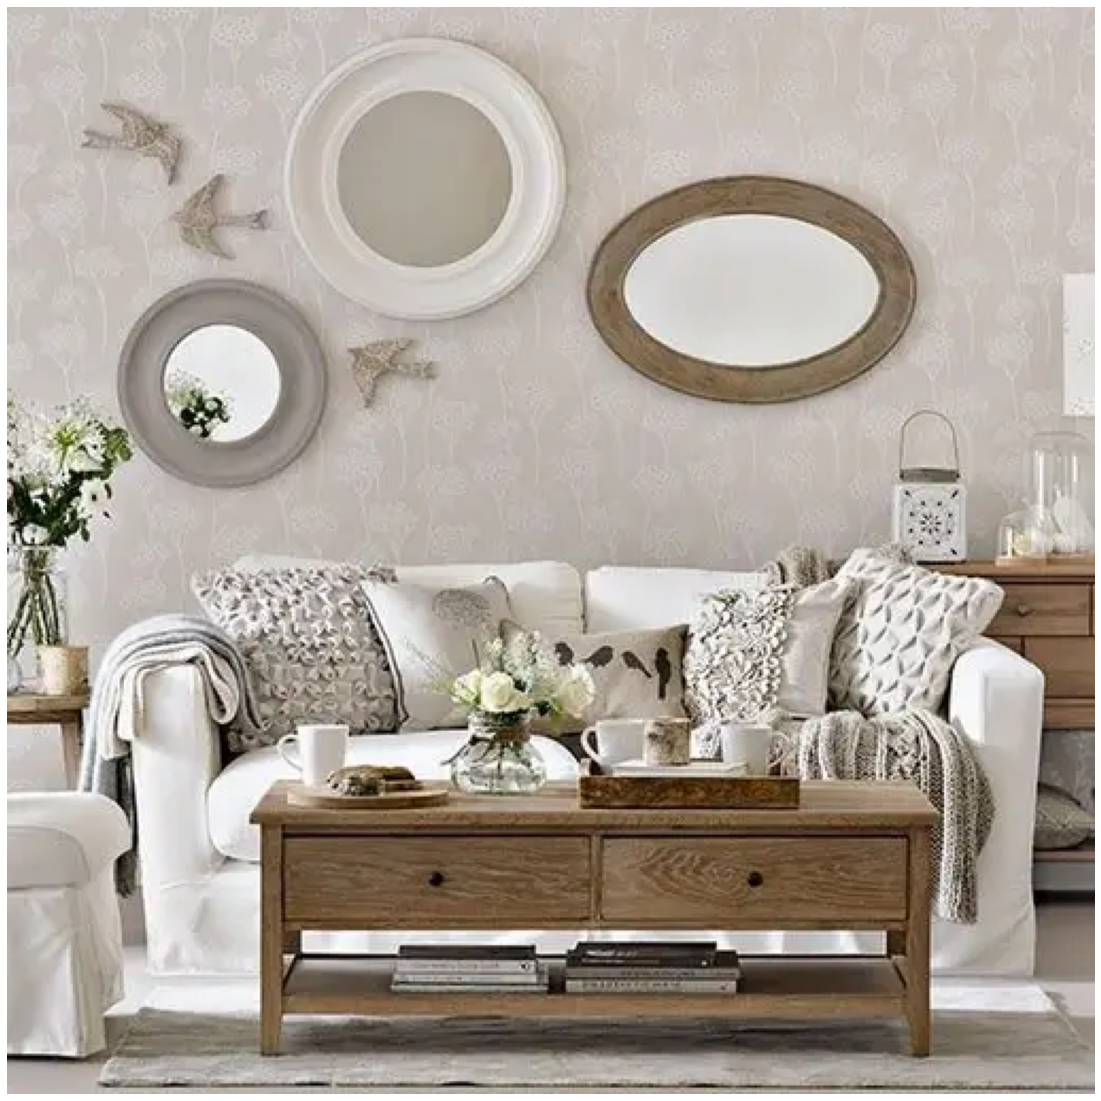

In [4]:
image = cv2.imread('data/zd_testimgs/-663378304158021540.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
dist.init_process_group('xla', init_method='pjrt://')

sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_h.pth"
model_type = "vit_h"
device = xm.xla_device()
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

sam.eval()
sam_dynamo = torch.compile(sam, backend='torchxla_trace_once')

mask_generator = SamAutomaticMaskGenerator(
    model=sam_dynamo,
    points_per_side=8,
    points_per_batch=64,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)

In [ ]:
masks = mask_generator.generate(image, multimask_output=False)
len(masks)

147

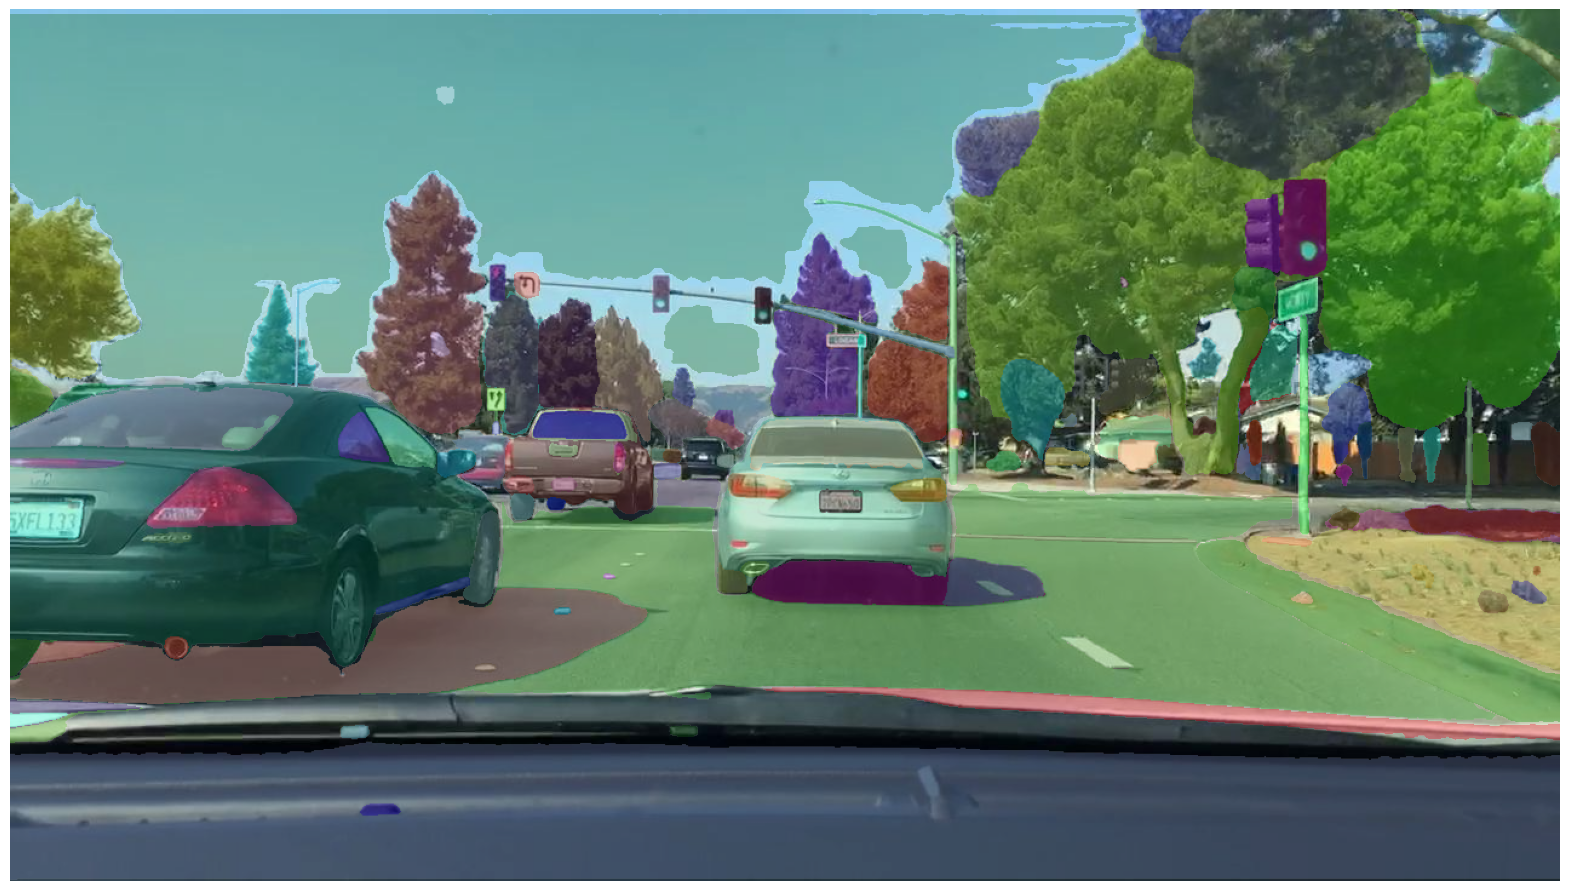

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()